# Movie Reviews Sentiment Analysis
By Tim hulak

## Introduction

This dataset was produced for the Kaggle competition, described here: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews , and which uses data from the sentiment analysis by Socher et al, detailed at this web site: http://nlp.stanford.edu/sentiment/. The data was taken from the original Pang and Lee movie review corpus based on reviews from the Rotten Tomatoes web site. Socher’s group used crowd-sourcing to manually annotate all the subphrases of sentences with a sentiment label ranging over: “negative”, “somewhat negative”, “neutral”, “somewhat positive”, “positive”.

Although the actual Kaggle competition is over, the data is still available at https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data. We are going to use the training data “train.tsv”, and some test data is also available “test.tsv”. There appear to be 156,060 phrases in the training data file, and one of the challenges will be to choose an appropriate subset for processing and training.

In [1]:
# Download VADER for sentiment analysis
# nltk.download('vader_lexicon')

In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import sentence_polarity
from nltk.corpus import stopwords

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
# VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

### Define Analysis Functions

In [4]:
def sentiment_labels(sentiment_code):
    """ Relabel the Sentimants based on the numeric code"""
    if sentiment_code == 0:
        return "Negative"
    elif sentiment_code == 1:
        return "Somewhat Negative"
    elif sentiment_code == 2:
        return "Neutral"
    elif sentiment_code == 3:
        return "Somewhat Positive"
    elif sentiment_code == 4:
        return "Positive"
    
def vader_sentiment_labels(vader_compound_score):
    """Relabel the Sentimants based on the compound score from VADER"""
    if vader_compound_score == 0:
        return "Neutral"
    elif vader_compound_score > 0 and vader_compound_score < 0.5:
        return "Somewhat Positive"
    elif vader_compound_score > 0.5 and vader_compound_score < 1:
        return "Positive"
    elif vader_compound_score < 0 and vader_compound_score > -0.5:
        return "Somewhat Negative"
    elif vader_compound_score < -0.5 and vader_compound_score > -1:
        return "Negative"
    
def vader_sentiment_labels_2(vader_compound_score):
    """
    Relabel the Sentimants based on the compound score from VADER
    Except only relabel positive and negative
    """
    if vader_compound_score > 0:
        return "Positive"
    elif vader_compound_score < 0:
        return "Negative"

def vader_sentiment_labels_3(vader_compound_score):
    """
    Relabel the Sentimants based on the compound score from VADER
    Except only relabel positive, neautral, and negative
    """
    if vader_compound_score == 0:
        return "Neutral"
    elif vader_compound_score > 0:
        return "Positive"
    elif vader_compound_score < 0:
        return "Negative"
        

### VADER analysis

In [5]:
test_phrase = "This is a good movie"

sid.polarity_scores(test_phrase)

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}

In [6]:
test_phrase_2 = "This is was the best, most awesome movie EVER MADE!!!"
sid.polarity_scores(test_phrase_2)

{'neg': 0.0, 'neu': 0.458, 'pos': 0.542, 'compound': 0.8877}

In [7]:
test_phrase_3 = "This is the WORST movie that has ever disgraced the screen"
sid.polarity_scores(test_phrase_3)

{'neg': 0.465, 'neu': 0.535, 'pos': 0.0, 'compound': -0.8331}

### Predict using VADER and compare to actual labels

In [8]:
# Read in Data
train = pd.read_csv("corpus/train.tsv", sep = '\t')

train.dropna(inplace=True)

train['Sentiment_Label'] = train['Sentiment'].apply(sentiment_labels)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_Label
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


In [9]:
train['Polarity_Score'] = train['Phrase'].apply(lambda review:sid.polarity_scores(review))
train['VADER_Score'] = train['Polarity_Score'].apply(lambda d:d['compound'])
train['VADER_Score'] = train['VADER_Score'].apply(vader_sentiment_labels)
del train['Polarity_Score']
train.dropna(inplace=True)
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_Label,VADER_Score
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative,Positive
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral,Somewhat Positive
2,3,1,A series,2,Neutral,Neutral
3,4,1,A,2,Neutral,Neutral
4,5,1,series,2,Neutral,Neutral


In [10]:
round(accuracy_score(train['Sentiment_Label'],train['VADER_Score']),3)

0.503

In [11]:
print(classification_report(train['Sentiment_Label'],train['VADER_Score']))

                   precision    recall  f1-score   support

         Negative       0.20      0.25      0.22      7072
          Neutral       0.67      0.70      0.68     79582
         Positive       0.24      0.48      0.32      9206
Somewhat Negative       0.37      0.25      0.30     27273
Somewhat Positive       0.36      0.31      0.33     32922

         accuracy                           0.50    156055
        macro avg       0.37      0.40      0.37    156055
     weighted avg       0.51      0.50      0.50    156055



In [12]:
print(confusion_matrix(train['Sentiment_Label'],train['VADER_Score']))

[[ 1774  1813   392  2048  1045]
 [ 3093 55357  3800  6935 10397]
 [  134  1703  4453   372  2544]
 [ 3123 11374  1618  6767  4391]
 [  824 11801  8034  2056 10207]]


### Retry VADER with only Positive, Negative, or Neautral

In [13]:
train = pd.read_csv("corpus/train.tsv", sep = '\t')

train.dropna(inplace=True)

conditions = [
    (train['Sentiment'].isin([3,4])),
    (train['Sentiment'].isin([2])),
    (train['Sentiment'].isin([0,1]))
]

values = ['Positive','Neutral','Negative']

train['Sentiment_Label'] = np.select(conditions,values)

train['Polarity_Score'] = train['Phrase'].apply(lambda review:sid.polarity_scores(review))
train['VADER_Score'] = train['Polarity_Score'].apply(lambda d:d['compound'])
train['VADER_Score'] = train['VADER_Score'].apply(vader_sentiment_labels_3)
del train['Polarity_Score']
train.dropna(inplace=True)

train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_Label,VADER_Score
0,1,1,A series of escapades demonstrating the adage ...,1,Negative,Positive
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral,Positive
2,3,1,A series,2,Neutral,Neutral
3,4,1,A,2,Neutral,Neutral
4,5,1,series,2,Neutral,Neutral


In [14]:
round(accuracy_score(train['Sentiment_Label'],train['VADER_Score']),3)

0.604

In [15]:
print(classification_report(train['Sentiment_Label'],train['VADER_Score']))

              precision    recall  f1-score   support

    Negative       0.51      0.40      0.45     34345
     Neutral       0.67      0.70      0.68     79582
    Positive       0.54      0.60      0.57     42133

    accuracy                           0.60    156060
   macro avg       0.57      0.56      0.57    156060
weighted avg       0.60      0.60      0.60    156060



In [16]:
print(confusion_matrix(train['Sentiment_Label'],train['VADER_Score']))

[[13712 13187  7446]
 [10028 55357 14197]
 [ 3391 13504 25238]]


### Retry VADER with only Positive and Negative

In [17]:
train = pd.read_csv("corpus/train.tsv", sep = '\t')

train.dropna(inplace=True)

conditions = [
    (train['Sentiment'].isin([3,4])),
    (train['Sentiment'].isin([2])),
    (train['Sentiment'].isin([0,1]))
]

values = ['Positive','Neutral','Negative']

train['Sentiment_Label'] = np.select(conditions,values)

train = train.loc[train['Sentiment_Label'] != 'Neutral']


train['Polarity_Score'] = train['Phrase'].apply(lambda review:sid.polarity_scores(review))
train['VADER_Score'] = train['Polarity_Score'].apply(lambda d:d['compound'])
train['VADER_Score'] = train['VADER_Score'].apply(vader_sentiment_labels_2)
del train['Polarity_Score']
train.dropna(inplace=True)

train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_Label,VADER_Score
0,1,1,A series of escapades demonstrating the adage ...,1,Negative,Positive
21,22,1,good for the goose,3,Positive,Positive
22,23,1,good,3,Positive,Positive
33,34,1,"the gander , some of which occasionally amuses...",1,Negative,Positive
46,47,1,amuses,3,Positive,Positive


In [18]:
round(accuracy_score(train['Sentiment_Label'],train['VADER_Score']),3)

0.782

In [19]:
print(classification_report(train['Sentiment_Label'],train['VADER_Score']))

              precision    recall  f1-score   support

    Negative       0.80      0.65      0.72     21158
    Positive       0.77      0.88      0.82     28629

    accuracy                           0.78     49787
   macro avg       0.79      0.76      0.77     49787
weighted avg       0.78      0.78      0.78     49787



In [20]:
print(confusion_matrix(train['Sentiment_Label'],train['VADER_Score']))

[[13712  7446]
 [ 3391 25238]]


### Vader on the test data

In [21]:
test = pd.read_csv("corpus/test.tsv", sep = '\t')

In [22]:
test['Polarity_Score'] = test['Phrase'].apply(lambda review:sid.polarity_scores(review))
test['VADER_Score'] = test['Polarity_Score'].apply(lambda d:d['compound'])
test['VADER_Score'] = test['VADER_Score'].apply(vader_sentiment_labels_3)
test.head()

,PhraseId,SentenceId,Phrase,Polarity_Score,VADER_Score
0,156061,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",Positive
1,156062,8545,An intermittently pleasing but mostly routine ...,"{'neg': 0.0, 'neu': 0.732, 'pos': 0.268, 'comp...",Positive
2,156063,8545,An,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral
3,156064,8545,intermittently pleasing but mostly routine effort,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",Positive
4,156065,8545,intermittently pleasing but mostly routine,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",Positive


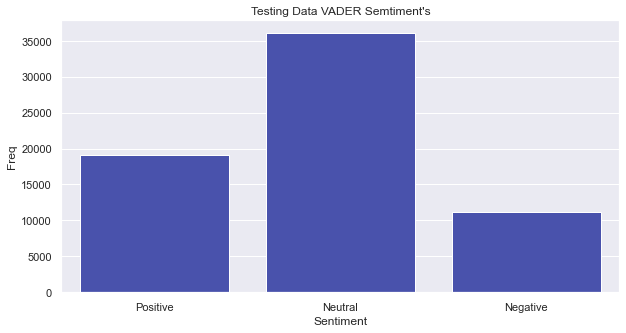

In [23]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.countplot(x ='VADER_Score', data = test,  palette=['#3944BC'])
plt.title("Testing Data VADER Semtiment's")
plt.xlabel("Sentiment")
plt.ylabel("Freq")
plt.show()

---

In [24]:
# import data
test = pd.read_csv("corpus/test.tsv", sep = '\t')
train = pd.read_csv("corpus/train.tsv", sep = '\t')

print("Test Data")
display(test.head())
print("\nTest Shape",test.shape)
print("\nTraining Data")
display(train.head())
print("\nTraining Shape:",train.shape,)

Test Data


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine



Test Shape (66292, 3)

Training Data


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2



Training Shape: (156060, 4)


### Sentiment Key:
- 0 = negative
- 1 = somewhat negative
- 2 = neutral
- 3 = somewhat positive
- 4 = positive

## Step 1: 

### Data Cleaning and EDA

In [25]:
# Redo labels 
train['Sentiment_Label'] = train['Sentiment'].apply(sentiment_labels)
# Create the length feature for both test and train
train['Review_Length'] = train['Phrase'].apply(len)
test['Review_Length'] = test['Phrase'].apply(len)

In [26]:
train.isnull().sum()

PhraseId           0
SentenceId         0
Phrase             0
Sentiment          0
Sentiment_Label    0
Review_Length      0
dtype: int64

In [27]:
train.isna().sum()

PhraseId           0
SentenceId         0
Phrase             0
Sentiment          0
Sentiment_Label    0
Review_Length      0
dtype: int64

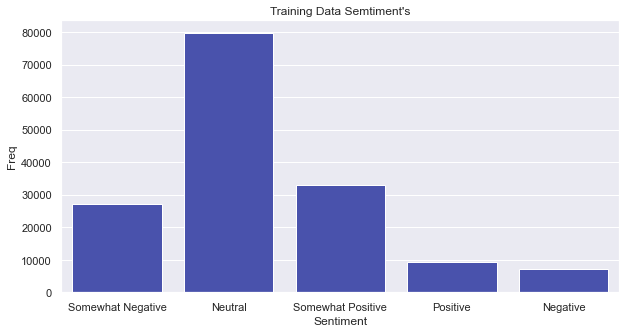

In [28]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.countplot(x ='Sentiment_Label', data = train,  palette=['#3944BC'])
plt.title("Training Data Semtiment's")
plt.xlabel("Sentiment")
plt.ylabel("Freq")
plt.show()

In [29]:
train['Sentiment'].describe()

count    156060.000000
mean          2.063578
std           0.893832
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: Sentiment, dtype: float64

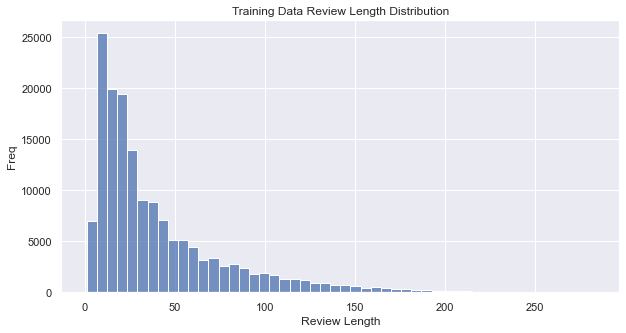

In [30]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.histplot(data=train, x="Review_Length", bins=50)
plt.title("Training Data Review Length Distribution")
plt.xlabel("Review Length")
plt.ylabel("Freq")
plt.show()

In [31]:
train['Review_Length'].describe()

count    156060.000000
mean         40.217224
std          38.154130
min           1.000000
25%          14.000000
50%          26.000000
75%          53.000000
max         283.000000
Name: Review_Length, dtype: float64

## Step 2:
### Naïve Bayes classifier

In [36]:
test.head()

,PhraseId,SentenceId,Phrase,Review_Length
0,156061,8545,An intermittently pleasing but mostly routine ...,54
1,156062,8545,An intermittently pleasing but mostly routine ...,52
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,49
4,156065,8545,intermittently pleasing but mostly routine,42


In [37]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_Label,Review_Length
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative,188
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral,77
2,3,1,A series,2,Neutral,8
3,4,1,A,2,Neutral,1
4,5,1,series,2,Neutral,6


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# instace of Pipeline
## Count Vectorization
# Fit vectorizer to data and transform text to vector
# Inverse document frequency and vectorization
# Create Naive Bayes Model
text_nb_pipeline = Pipeline([('tfidf',TfidfVectorizer()),('nb',MultinomialNB())])


In [62]:
# X  Feature data
X = train['Phrase']
# y label
y = train['Sentiment_Label']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [63]:
# Fit the model
text_nb_pipeline.fit(X_train, y_train)

# Predict with the model
predictions = text_nb_pipeline.predict(X_test)

# Evaluate Model
print("Accuracy ",round(accuracy_score(y_test,predictions),3))

Accuracy  0.582


In [64]:
print(confusion_matrix(y_test,predictions))

[[   60  1177     0   845    31]
 [    9 21281    19   889  1390]
 [    0  1028   130    12  1678]
 [   29  6003     1  1995   200]
 [    0  6106    50   114  3771]]


In [65]:
print(classification_report(y_test,predictions))

                   precision    recall  f1-score   support

         Negative       0.61      0.03      0.05      2113
          Neutral       0.60      0.90      0.72     23588
         Positive       0.65      0.05      0.09      2848
Somewhat Negative       0.52      0.24      0.33      8228
Somewhat Positive       0.53      0.38      0.44     10041

         accuracy                           0.58     46818
        macro avg       0.58      0.32      0.33     46818
     weighted avg       0.57      0.58      0.52     46818



## Predict on Test Data

In [66]:
new_predictions = text_nb_pipeline.predict(test['Phrase'])

In [71]:
predict_col = list(new_predictions)
test['Predicted_Sentiment'] = predict_col
test.head(15)

,PhraseId,SentenceId,Phrase,Review_Length,Predicted_Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,54,Somewhat Positive
1,156062,8545,An intermittently pleasing but mostly routine ...,52,Somewhat Positive
2,156063,8545,An,2,Neutral
3,156064,8545,intermittently pleasing but mostly routine effort,49,Somewhat Positive
4,156065,8545,intermittently pleasing but mostly routine,42,Somewhat Positive
5,156066,8545,intermittently pleasing but,27,Somewhat Positive
6,156067,8545,intermittently pleasing,23,Somewhat Positive
7,156068,8545,intermittently,14,Somewhat Positive
8,156069,8545,pleasing,8,Somewhat Positive
9,156070,8545,but,3,Neutral


In [72]:
test['Polarity_Score'] = test['Phrase'].apply(lambda review:sid.polarity_scores(review))
test['VADER_Score'] = test['Polarity_Score'].apply(lambda d:d['compound'])
test['VADER_Score'] = test['VADER_Score'].apply(vader_sentiment_labels)
del test['Polarity_Score']
test.dropna(inplace=True)

,PhraseId,SentenceId,Phrase,Review_Length,Predicted_Sentiment,VADER_Score
0,156061,8545,An intermittently pleasing but mostly routine ...,54,Somewhat Positive,Somewhat Positive
1,156062,8545,An intermittently pleasing but mostly routine ...,52,Somewhat Positive,Somewhat Positive
2,156063,8545,An,2,Neutral,Neutral
3,156064,8545,intermittently pleasing but mostly routine effort,49,Somewhat Positive,Somewhat Positive
4,156065,8545,intermittently pleasing but mostly routine,42,Somewhat Positive,Somewhat Positive


In [73]:
test.head(15)

,PhraseId,SentenceId,Phrase,Review_Length,Predicted_Sentiment,VADER_Score
0,156061,8545,An intermittently pleasing but mostly routine ...,54,Somewhat Positive,Somewhat Positive
1,156062,8545,An intermittently pleasing but mostly routine ...,52,Somewhat Positive,Somewhat Positive
2,156063,8545,An,2,Neutral,Neutral
3,156064,8545,intermittently pleasing but mostly routine effort,49,Somewhat Positive,Somewhat Positive
4,156065,8545,intermittently pleasing but mostly routine,42,Somewhat Positive,Somewhat Positive
5,156066,8545,intermittently pleasing but,27,Somewhat Positive,Somewhat Positive
6,156067,8545,intermittently pleasing,23,Somewhat Positive,Positive
7,156068,8545,intermittently,14,Somewhat Positive,Neutral
8,156069,8545,pleasing,8,Somewhat Positive,Positive
9,156070,8545,but,3,Neutral,Neutral


In [76]:
print("Accuracy ",round(accuracy_score(test['Predicted_Sentiment'],test['VADER_Score']),3))

Accuracy  0.542


In [74]:
print(confusion_matrix(test['Predicted_Sentiment'],test['VADER_Score']))

[[    8    14     0    10     0]
 [ 2896 32125  4300  5920  8770]
 [    0    63    32     2    35]
 [  641  1481    92  1085   405]
 [  121  2343  2829   443  2677]]


In [75]:
print(classification_report(test['Predicted_Sentiment'],test['VADER_Score']))

                   precision    recall  f1-score   support

         Negative       0.00      0.25      0.00        32
          Neutral       0.89      0.59      0.71     54011
         Positive       0.00      0.24      0.01       132
Somewhat Negative       0.15      0.29      0.19      3704
Somewhat Positive       0.23      0.32      0.26      8413

         accuracy                           0.54     66292
        macro avg       0.25      0.34      0.24     66292
     weighted avg       0.76      0.54      0.63     66292



In [77]:
from sklearn.metrics import plot_confusion_matrix

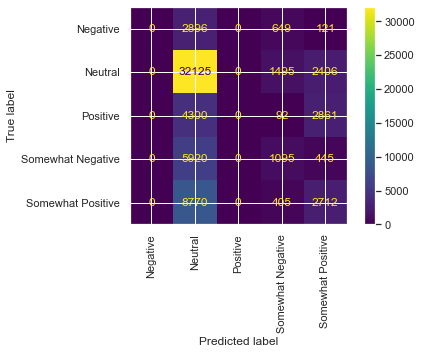

In [85]:
plot_confusion_matrix(text_nb_pipeline, test['Predicted_Sentiment'], test['VADER_Score']) 
plt.xticks(rotation=90)
plt.show()

In [96]:
pred = test['Predicted_Sentiment'].value_counts().to_frame().reset_index()

In [97]:
vdr = test['VADER_Score'].value_counts().to_frame().reset_index()

In [107]:
compare_df = pd.DataFrame({
    "Sentiment": pred['index'],
    "NB": pred['Predicted_Sentiment'],
    "VADER": vdr['VADER_Score']
})
compare_df['Difference'] = compare_df['NB'] - compare_df['VADER']
compare_df

,Sentiment,NB,VADER,Difference
0,Neutral,54011,36026,17985
1,Somewhat Positive,8413,11887,-3474
2,Somewhat Negative,3704,7460,-3756
3,Positive,132,7253,-7121
4,Negative,32,3666,-3634


<Figure size 720x360 with 0 Axes>

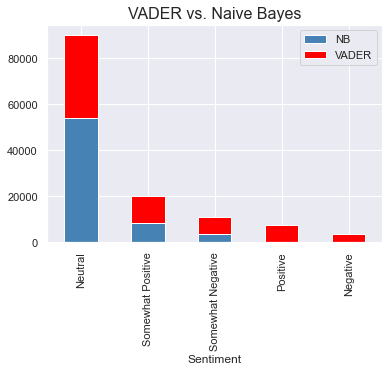

In [108]:
del compare_df['Difference']
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
compare_df.set_index('Sentiment').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
plt.title('VADER vs. Naive Bayes', fontsize=16)
plt.show()

## Step 3:
A. For a base level completion of experiments, carry out at least several experiments where you use two different sets of features and compare the results. For example, you may take the unigram word features as a baseline and see if the features you designed improve the accuracy of the classification. Here are some of the types of experiments that we have done so far:

- filter by stopwords or other pre-processing methods
- representing negation (if using twitter data, note the difference in tokenization)
- using a sentiment lexicon with scores or counts: Subjectivity
- different sizes of vocabularies
- POS tag features

You must define at least one “new” feature function not given in class. Also you should try to combine some of the earlier features, e.g. to use unigrams, bigrams, POS tag counts, and sentiment word counts all in one feature set. Examples of new features:

- Use the LIWC sentiment lexicon
- combine the use of sentiment lexicons
- use a different representation of negation, for example, carrying the scope of the negation work over to the next punctuation

B. Choose an additional, more advanced type of task from this list, or propose your own

- using Weka or Sci Kit Learn classifiers with features produced in NLTK. Note that you
should not use the built-in vectorizers from Weka or Sci Kit Learn.

- using an additional type of lexicon besides Subjectivity or LIWC

- in addition to using cross-validation on the training set, train the classifier on the entiretraining set and test it on a separately available test set (only the SemEval data has these) 
    - note that you must save the vocabulary from the training set and use the same for
creating feature sets for the test data
- implement additional features

    - in the email dataset, use word frequency or tfidf scores as the values of the word features, instead of Boolean values
    - use POS tagging from the ARK on Twitter
    - twitter emoticons or other features based on internet usage or informal text, such as repeated letters, or all caps words


## Step 4: 
Write a report that describes the data processing, the features and the classification experiment(s). As one of your experiments, you may instead compare results from different classifier algorithms in Weka or Sci-Kit Learn.